In [22]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm


In [23]:

# --- Load and preprocess ---
df = pd.read_csv("/Users/Patron/Documents/brain-waves-classification/hms_data/eeg_spect_full_features.csv")

In [24]:
eeg_cols = [col for col in df.columns if col.startswith(('Fp1_', 'O1_', 'O2_', 'Fp2_'))]
spec_cols = [col for col in df.columns if col.startswith(('LL_', 'RL_', 'LP_', 'RP_'))]


In [25]:
X_eeg = df[eeg_cols].values
X_spect = df[spec_cols].values
y_raw = df['expert_consensus'].values
le = LabelEncoder()
y = le.fit_transform(y_raw)


In [26]:
# --- Split into train, val, test (70/15/15) ---
X_eeg_temp, X_eeg_test, X_spect_temp, X_spect_test, y_temp, y_test = train_test_split(
    X_eeg, X_spect, y, test_size=0.15, stratify=y, random_state=42)

X_eeg_train, X_eeg_val, X_spect_train, X_spect_val, y_train, y_val = train_test_split(
    X_eeg_temp, X_spect_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42)  # 0.1765 * 0.85 ≈ 0.15


In [27]:
# --- Normalize ---
scaler_eeg = StandardScaler()
X_eeg_train_scaled = scaler_eeg.fit_transform(X_eeg_train)
X_eeg_val_scaled = scaler_eeg.transform(X_eeg_val)
X_eeg_test_scaled = scaler_eeg.transform(X_eeg_test)

scaler_spec = StandardScaler()
X_spect_train_scaled = scaler_spec.fit_transform(X_spect_train)
X_spect_val_scaled = scaler_spec.transform(X_spect_val)
X_spect_test_scaled = scaler_spec.transform(X_spect_test)

In [28]:
# --- Reshape for CNNs ---
X_spect_train_img = X_spect_train_scaled.reshape(-1, 4, 4, 1)
X_spect_val_img = X_spect_val_scaled.reshape(-1, 4, 4, 1)
X_spect_test_img = X_spect_test_scaled.reshape(-1, 4, 4, 1)


In [29]:
# --- EfficientNet-style CNN ---
input_img = Input(shape=(4, 4, 1))
x = GlobalAveragePooling2D()(input_img)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(6, activation='softmax')(x)


In [30]:
eff_model = Model(input_img, output)
eff_model.compile(optimizer=Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

eff_model.fit(
    X_spect_train_img, y_train,
    epochs=100, batch_size=32, validation_data=(X_spect_val_img, y_val),
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)

Epoch 1/100
2337/2337 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.1927 - loss: 1.7830 - val_accuracy: 0.1968 - val_loss: 1.7778
Epoch 2/100
2337/2337 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - accuracy: 0.1975 - loss: 1.7774 - val_accuracy: 0.1973 - val_loss: 1.7771
Epoch 3/100
2337/2337 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - accuracy: 0.1982 - loss: 1.7771 - val_accuracy: 0.2001 - val_loss: 1.7756
Epoch 4/100
2337/2337 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/step - accuracy: 0.1983 - loss: 1.7768 - val_accuracy: 0.1923 - val_loss: 1.7764
Epoch 5/100
2337/2337 ━━━━━━━━━━━━━━━━━━━━ 1s 456us/step - accuracy: 0.1980 - loss: 1.7759 - val_accuracy: 0.1961 - val_loss: 1.7752
Epoch 6/100
2337/2337 ━━━━━━━━━━━━━━━━━━━━ 1s 456us/step - accuracy: 0.1992 - loss: 1.7755 - val_accuracy: 0.1969 - val_loss: 1.7754
Epoch 7/100
2337/2337 ━━━━━━━━━━━━━━━━━━━━ 1s 460us/step - accuracy: 0.1961 - loss: 1.7774 - val_accuracy: 0.2005 - val_loss: 1.7745
Epoch 8/100
2337/2337 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 

In [31]:
def predict_model(model, data):
    return np.vstack([
        model.predict(np.expand_dims(data[i], axis=0), verbose=0)
        for i in tqdm(range(len(data)))
    ])

eff_preds_train = predict_model(eff_model, X_spect_train_img)
eff_preds_val = predict_model(eff_model, X_spect_val_img)
eff_preds_test = predict_model(eff_model, X_spect_test_img)

100%|██████████| 16020/16020 [06:48<00:00, 39.25it/s]


In [32]:
# --- PyTorch CNN on EEG data ---
class EEG_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 2, padding=1)
        dummy = torch.zeros(1, 1, 4, 4)
        out = self._forward_conv(dummy)
        self.fc1 = nn.Linear(out.view(1, -1).size(1), 128)
        self.out = nn.Linear(128, 6)

    def _forward_conv(self, x):
        x = F.relu(self.conv1(x))
        return F.relu(self.conv2(x))

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.out(x)

In [33]:
def cnn_predict(model, X):
    model.eval()
    preds = []
    with torch.no_grad():
        for i in tqdm(range(len(X))):
            out = model(X[i].unsqueeze(0))
            preds.append(out.numpy())
    return np.vstack(preds)

In [34]:
X_eeg_train_tensor = torch.tensor(X_eeg_train_scaled, dtype=torch.float32).view(-1, 1, 4, 4)
X_eeg_val_tensor = torch.tensor(X_eeg_val_scaled, dtype=torch.float32).view(-1, 1, 4, 4)
X_eeg_test_tensor = torch.tensor(X_eeg_test_scaled, dtype=torch.float32).view(-1, 1, 4, 4)

cnn_model = EEG_CNN()
cnn_preds_train = cnn_predict(cnn_model, X_eeg_train_tensor)
cnn_preds_val = cnn_predict(cnn_model, X_eeg_val_tensor)
cnn_preds_test = cnn_predict(cnn_model, X_eeg_test_tensor)

100%|██████████| 16020/16020 [00:01<00:00, 14916.23it/s]


In [42]:
# --- XGBoost ---
xgb_model = xgb.XGBClassifier(objective="multi:softprob", num_class=6, eval_metric="mlogloss", use_label_encoder=False)
xgb_model.fit(X_spect_train_scaled, y_train, eval_set=[(X_spect_val_scaled, y_val)], verbose=False)

xgb_preds_train = xgb_model.predict_proba(X_spect_train_scaled)
xgb_preds_val = xgb_model.predict_proba(X_spect_val_scaled)
xgb_preds_test = xgb_model.predict_proba(X_spect_test_scaled)

In [43]:
# --- Random Forest ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_eeg_train_scaled, y_train)

rf_preds_train = rf_model.predict_proba(X_eeg_train_scaled)
rf_preds_val = rf_model.predict_proba(X_eeg_val_scaled)
rf_preds_test = rf_model.predict_proba(X_eeg_test_scaled)


In [44]:
# --- Ensemble ---
X_train_ensemble = np.concatenate([cnn_preds_train, eff_preds_train, xgb_preds_train, rf_preds_train], axis=1)
X_val_ensemble = np.concatenate([cnn_preds_val, eff_preds_val, xgb_preds_val, rf_preds_val], axis=1)
X_test_ensemble = np.concatenate([cnn_preds_test, eff_preds_test, xgb_preds_test, rf_preds_test], axis=1)

ensemble_model = LogisticRegression(max_iter=1000, multi_class='multinomial')
ensemble_model.fit(X_train_ensemble, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [45]:
y_pred_train = ensemble_model.predict(X_train_ensemble)
y_pred_val = ensemble_model.predict(X_val_ensemble)
y_pred_test = ensemble_model.predict(X_test_ensemble)

In [46]:
print(f"\n✅ Ensemble Accuracies:")
print(f"Train: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Val:   {accuracy_score(y_val, y_pred_val):.4f}")
print(f"Test:  {accuracy_score(y_test, y_pred_test):.4f}")

print("\n📊 Classification Report (Test Set):\n")
print(classification_report(y_test, y_pred_test, target_names=le.classes_))


✅ Ensemble Accuracies:
Train: 0.9676
Val:   0.9374
Test:  0.9352

📊 Classification Report (Test Set):

              precision    recall  f1-score   support

         GPD       0.97      0.95      0.96      2505
        GRDA       0.98      0.96      0.97      2829
         LPD       0.90      0.90      0.90      2229
        LRDA       0.95      0.95      0.95      2496
       Other       0.88      0.91      0.90      2821
     Seizure       0.93      0.92      0.93      3140

    accuracy                           0.94     16020
   macro avg       0.94      0.93      0.94     16020
weighted avg       0.94      0.94      0.94     16020



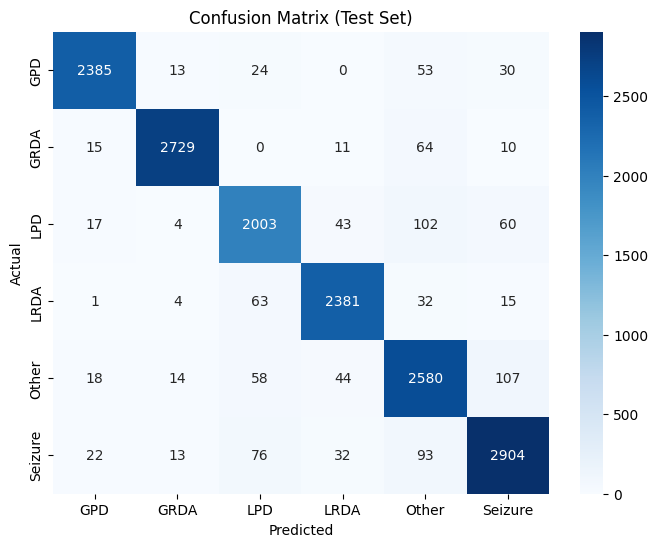

In [47]:
# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.show()